# BIOMEDICAL COMPUTER VISION PROJECT

The aim of this project is to enhance and preprocess a provided biomedical dataset, and to effectively segment regions of interest such as liver, kindey and spleen

## IMPORT AND INSTALL

Let's install and import some essential libraries!

In [2]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import exposure
from skimage.filters import threshold_otsu
from sklearn import cluster
from skimage import data
from glob import glob
import skimage.transform
import os
from scipy.ndimage import zoom
from skimage import exposure
from PIL import Image
from google.colab import drive
import pydicom as dicom


In [4]:
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

In [6]:
import datetime

## SETUP

In [8]:
drive.mount('/content/drive')
os.chdir(f'/content/drive/MyDrive/BICV')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/.shortcut-targets-by-id/1in6BApveq43n_DGPuAk0x_6Z_OatxQ_M/BICV'

In [9]:
rootfolder = '/content/drive/MyDrive/BICV/dataset/Train_Sets/MR'
InPhase_path = "T1DUAL/DICOM_anon/InPhase/"
ground_path = "T1DUAL/Ground/"
dcm_ext = '.dcm'
img_ext = '.png'
suffixes = [InPhase_path, ground_path]

## CLASS DEFINITION

The *Abstract_dataPoint* class helps manage and process image data, making it easier to work with both raw and processed images.



In [10]:
class Abstract_dataPoint:
  def __init__(self, path):
    # Initialize the class with the provided file path
    self.path = path
    # Raw (unprocessed) image data
    self.img_data_raw = None
    # Processed image data
    self.img_data_processed = None

  # Return the index of the middle slice along the first axis
  def get_middle_slice(self, data):
    return int(np.round(data.shape[0]/2))

  # Display the middle slice of the raw image data
  def display_image_raw(self):
    canva = plt.figure(figsize=(4,4))
    subplot = canva.add_subplot(1,1,1)
    imgPlt = plt.imshow(self.img_data_raw[self.get_middle_slice(self.img_data_raw), :, :], cmap ='gray')

  # Display the middle slice of the processed image data
  def display_image_processed(self):
    canva = plt.figure(figsize=(4,4))
    subplot = canva.add_subplot(1,1,1)
    imgPlt = plt.imshow(self.img_data_processed[self.get_middle_slice(self.img_data_processed), :, :], cmap ='gray')

  # Resize the processed image data to a target shape of (192, 192, 192)
  def resizing(self, interpolation_order):
    target_shape = [192, 192, 192]
    factors = (
        target_shape[0]/self.img_data_processed.shape[0],
        target_shape[1]/self.img_data_processed.shape[1],
        target_shape[2]/self.img_data_processed.shape[2]
    )
    self.img_data_processed = zoom(self.img_data_processed, factors, order=interpolation_order, mode='nearest')

  # Return the middle slice of the processed image data
  def get_image(self, index=None):
    return self.img_data_processed[self.get_middle_slice(self.img_data_processed), :, :]


The *MR class* extends the Abstract_dataPoint class to handle MRI data, providing methods to read, preprocess, and manipulate MRI images

In [11]:
class MR(Abstract_dataPoint):
  def __init__(self, path):
    super().__init__(path)
    img_volume = []
    # Walk through the directory and read DICOM files
    for path, _, files in sorted(os.walk(self.path)):
      for filename in (sorted(files)):
        if filename.endswith(dcm_ext):
          img_dcm_std = dicom.dcmread(os.path.join(self.path, filename))
          img = img_dcm_std.pixel_array
          img_volume.append(img)
    self.img_data_raw = np.array(img_volume)
    # Extract voxel dimensions from DICOM metadata
    x_space = img_dcm_std.PixelSpacing[0]
    y_space = img_dcm_std.PixelSpacing[1]
    z_space = img_dcm_std.SpacingBetweenSlices

    self.voxel_dims = (x_space, y_space, z_space)
    self.img_data_processed = self.img_data_raw

  # Resample image data to target resolution of 1x1x1 mm
  def resampling(self):
    target_resolution = [1, 1, 1]
    scale_vector = (self.voxel_dims[0]/target_resolution[0],
                    self.voxel_dims[1]/target_resolution[1],
                    self.voxel_dims[2]/target_resolution[2]
                    )
    self.voxel_dims = target_resolution
    # Apply rescaling with interpolation order 3
    self.img_data_processed = skimage.transform.rescale(self.img_data_processed,
                                                        scale_vector,
                                                        order = 3,
                                                        preserve_range=True,
                                                        mode='constant')
  # Standardize image data to zero mean and unit variance
  def standardization(self):
    zero_mean = False
    if zero_mean == True:
        img_o = np.float32(self.img_data_processed_std.copy())
        m = np.mean(img_o)
        s = np.std(img_o)
        self.img_data_processed= np.divide((img_o - m), s)
    else:
        perc1 = np.percentile(self.img_data_processed,1)
        perc99 = np.percentile(self.img_data_processed, 99)
        self.img_data_processed = np.divide((self.img_data_processed - perc1), (perc99 - perc1))
        self.img_data_processed[self.img_data_processed < 0] = 0.0
        self.img_data_processed[self.img_data_processed > 1] = 1.0

  # Normalize image data to range [0, 255]
  def normalization(self):
    self.img_data_processed = cv.normalize(self.img_data_processed,
                                            None,
                                            alpha=0,
                                            beta=255,
                                            norm_type=cv.NORM_MINMAX,
                                            dtype=cv.CV_8UC1)
  # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
  def equalization(self):
    clahe_img = cv.createCLAHE (clipLimit = 2.0, tileGridSize = (8, 8))
    eqlzd = np.empty(shape=(192, 192, 192))
    for i in range(192):
      eqlzd[i, :, :] = clahe_img.apply(self.img_data_processed[i, :, :])
    self.img_data_processed = eqlzd

  # Perform all preprocessing steps in sequence
  def preProcessing(self):
    self.resampling()
    self.resizing(interpolation_order=3)
    self.standardization()
    self.normalization()
    self.equalization()

  # string representation of the object with relevant details
  def __str__(self):
    return self.path + "\n" + \
       "Raw data shape:\n" + str(self.img_data_raw.shape) + "\n" + \
       "Preprocessed data shape:\n" + str(self.img_data_processed.shape) + "\n" + \
       "Voxel dimensions shape:\n" + str(self.voxel_dims)



The *Segmentation* class is designed to handle segmentation data, inheriting functionality from the Abstract_dataPoint class. It facilitates the preprocessing and management of segmentation images

In [12]:
class Segmentation(Abstract_dataPoint):
  def __init__(self, path):
    super().__init__(path)

    img_seg = []
    # Read segmentation images from the specified path
    for path,_,files in sorted(os.walk(self.path)):
      for filename in (sorted(files)):
        if filename.endswith(img_ext):
          img = np.array(Image.open(os.path.join(path, filename)))
          img_seg.append(img)
    # Convert the list of segmentation images to a numpy array
    self.img_data_raw = np.array(img_seg)
    self.img_data_processed = self.img_data_raw

  # Preprocess segmentation images by resizing using nearest-neighbor interpolation (order 0)
  def preProcessing(self):
    self.resizing(interpolation_order=0)
  # String representation of the object with relevant details
  def __str__(self):
    return self.path + "\n"  + "Preprocessed data shape: " + str(self.img_data_processed.shape)


The *MRDataset* class serves as a utility for managing datasets containing both MRI volumes and corresponding segmentation volumes. It provides methods for preprocessing, shuffling, concatenating volumes, and visualizing images

In [13]:
class MRDataset:
  def __init__(self, rootfolder, suffixes):
    self.rootFolder = rootfolder
    self.MR_volumes = self.create_volumes(suffixes[0])
    self.Seg_volumes = self.create_volumes(suffixes[1])

  # Create volumes based on the suffix type (MRI or segmentation)
  def create_volumes(self,suffix):
      paths = sorted(glob(os.path.join(self.rootFolder,'*',suffix)))
      volumes_list = []
      for path in paths:
        if suffix.endswith('/Ground/'):
          volume = Segmentation(path)
          print(volume)
        else:
          volume = MR(path)
          print(volume)
        volumes_list.append(volume)
      return volumes_list

  # Shuffle the order of MRI and segmentation volumes
  def shuffle_volumes(self):
    self.MR_volumes, self.Seg_volumes = shuffle(self.MR_volumes, self.Seg_volumes )

  # Apply preprocessing steps to MRI and segmentation volumes
  def preProcessing(self):
    for mr in self.MR_volumes:
      print(mr)
      mr.preProcessing()
      print(mr)
    for seg in self.Seg_volumes:
      print(seg)
      seg.preProcessing()
      print(seg)

  # Concatenate MRI volumes into a single array
  def concatenate_MR_volumes(self):
    #return np.concatenate([self.MR_volumes[i].img_data_processed for i in range(len(self.MR_volumes))], axis =0)
    return np.concatenate([np.expand_dims(self.MR_volumes[i].img_data_processed, axis=-1) for i in range(len(self.MR_volumes))], axis =0)
  # Concatenate segmentation volumes into a single array
  def concatenate_Seg_volumes(self):
    #return np.concatenate([self.Seg_volumes[i].img_data_processed for i in range(len(self.Seg_volumes))], axis =0)
     return np.concatenate([np.expand_dims(self.Seg_volumes[i].img_data_processed, axis=-1) for i in range(len(self.Seg_volumes))], axis =0)

  # Display an MRI image and its corresponding segmentation mask
  def image_viewer(self, volumeIndex=None):
    volumeList = self.MR_volumes
    if volumeIndex == None:
      volumeIndex = 1
    mr_image = self.MR_volumes[volumeIndex].get_image()
    canva, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].set_title('Image')
    axes[0].imshow(mr_image, cmap ='gray')
    axes[1].set_title("Mask")
    seg_image = self.Seg_volumes[volumeIndex].get_image()
    axes[1].imshow(seg_image, cmap ='gray')


## UTILS

The *image_viewer* function is designed to visualize images and their corresponding labels/masks with optional overlay

In [45]:
def image_viewer(data, labels, uniques_labels ,index=None):
  # If index is not provided, select a random index within the data range
  if index == None:
    index = np.random.randint(0, len(data))
  fig, axes = plt.subplots(1, 3, figsize=(12,4))

  # Display the original image
  axes[0].set_title("Image")
  axes[0].imshow(data[index])

  # Display the mask with unique labels colored accordingly
  axes[1].set_title("Mask")
  cmap = plt.get_cmap('hot')
  colors  = cmap(np.linspace(0, 1, len(uniques_labels)))
  colored_image = colors[labels[index]]
  axes[1].imshow(np.squeeze(colored_image))

  # Display the overlay of the image and mask
  axes[2].set_title("Overlay")
  axes[2].imshow(data[index])
  overlay_alpha = 0.5
  axes[2].imshow(np.squeeze(colored_image), alpha=overlay_alpha)

  plt.show()

The *predictions_image_viewer* function visualizes original images, true masks, and predicted masks generated by a given model. It allows for comparison between ground truth masks and predicted masks, facilitating evaluation of model performance

In [46]:
def predictions_image_viewer(model, data, labels, unique_labels, index=None):
   # If index is not provided, select a random index within the data range
  if index == None:
    index = np.random.randint(0, len(data))

  fig, axes = plt.subplots(1, 3, figsize=(12,4))

  # Display the original image
  axes[0].set_title('Image')
  axes[0].imshow(data[index])

  # Display the ground truth mask with unique labels colored accordingly
  axes[1].set_title('True Mask')
  cmap = plt.get_cmap('hot')
  colors = cmap(np.linspace(0, 1, len(unique_labels)))
  colored_image = colors[labels[index]]
  axes[1].imshow(np.squeeze(colored_image))

  # Generate predictions using the model and display the predicted mask
  axes[2].set_title('Predicted Mask')
  cmap_pred = plt.get_cmap('hot')
  colors_pred = cmap_pred(np.linspace(0, 1, len(unique_labels)))
  colored_image_pred = colors_pred[compute_predictions(model,data[index])]
  axes[2].imshow(np.squeeze(colored_image_pred))

  plt.show()

The *assign_category* function assigns a category label to a given numerical value based on predefined ranges:
* Category 1 - Liver : Values in the range [55, 70]
* Category 2 - Right kidney: Values in the range [110, 135]
* Category 3 - Left kidney: Values in the range [175, 200]
* Category 4 - Spleen: Values in the range [240, 255]
* Unlabelled - background


In [47]:
def assign_category(value):
  # Define categories with corresponding numerical ranges
  categories = {range(55,71):1, range(110, 136):2, range(175, 201):3, range(240, 256):4}
  # Iterate over defined ranges to assign category label
  for range_, category in categories.items():
    if value in range_:
      return category
  return 0 # Unlabelled

The *train_test_split* function partitions the given data and labels into training and testing sets based on the specified train size and number of slices, ensuring that slices are considered as separate entities during splitting. It also provides an option to shuffle the data before splitting.

In [48]:
def train_test_split(data, labels, train_size, n_slices, shuffled=True):
  # Shuffle the data before splitting if required
  if shuffled == True:
    X_train, Y_train = shuffle(data[:n_slices*train_size], labels[:n_slices*train_size], random_state=0)
    X_test, Y_test = shuffle(data[n_slices*train_size:], labels[n_slices*train_size:],  random_state=0)
  else:
    # Split the data into training and testing sets without shuffling
    X_train, Y_train = data[:n_slices*train_size], labels[:n_slices*train_size]
    X_test, Y_test = data[n_slices*train_size:], labels[n_slices*train_size:]

  return X_train, Y_train, X_test, Y_test

The *compute_predictions* function generates predictions for selected data using a given model. It expands the dimensions of the data, performs predictions using the model, and reshapes the predicted labels to match the original data dimensions.

In [49]:
def compute_predictions(model, selected_data):
    # Expand the dimensions of the selected data to match the model input shape
    expanded_data = np.expand_dims(selected_data, axis=0)
    # Generate predictions using the model
    predictions = model.predict(expanded_data, verbose=0)
    # Extract the predicted labels by selecting the class with the highest probability
    predicted_labels = np.array(tf.math.argmax(predictions, axis=-1))
    # Reshape the predicted labels to match the dimensions of the original data
    reshaped_predictions = np.reshape(predicted_labels, (192, 192, 1))

    return reshaped_predictions

## DATASET LOADING

In [ ]:
# Create an instance of MRDataset containing MRI images and segmentation masks
mr_image_and_labels = MRDataset(rootfolder, suffixes)

In [ ]:
# Visualize a random sample from the dataset
mr_image_and_labels.image_viewer()

## DATA PREPROCESSING

In [ ]:
# Preprocess the MRI and segmentation data
mr_image_and_labels.preProcessing()

In [ ]:
# Concatenate MRI volumes and segmentation volumes
mr_image_volumes = mr_image_and_labels.concatenate_MR_volumes()
seg_image_volumes = mr_image_and_labels.concatenate_Seg_volumes()

In [ ]:
print( "mr_image_volumes shape: "+ str(mr_image_volumes.shape)+ ", seg_image_volumes: " + str(seg_image_volumes.shape))

In [ ]:
mr_image_and_labels.image_viewer()

In [ ]:
# Map segmentation categories to numerical label
seg_mapped_categories = np.vectorize(assign_category)(seg_image_volumes)
unique_labels, counts = np.unique(seg_mapped_categories, return_counts=True)

In [ ]:
print("Unique labels: " + str(unique_labels) + ", counts per class:  " + str(counts))

In [ ]:
# Compute unique labels and their counts
image_viewer(mr_image_volumes, seg_mapped_categories, unique_labels)

In [ ]:
# Save processed data as a compressed numpy archive file
np.savez('processed-nparray-MR-T1DUAL-InPhase.npz', mr_image_volumes=mr_image_volumes,  seg_mapped_categories=seg_mapped_categories)

## TRAIN, VALIDATION AND TEST SETS

In [17]:
NUM_LABELS = 5

In [18]:
# Load .npz
loaded_data = np.load('processed-nparray-MR-T1DUAL-InPhase.npz')
mr_image_volumes= loaded_data['mr_image_volumes']
seg_mapped_categories = loaded_data['seg_mapped_categories']

In [19]:
# Split data into training and testing sets
X_train, Y_train, X_test, Y_test = train_test_split(data=mr_image_volumes, labels=seg_mapped_categories, train_size=18, n_slices=192, shuffled=True)
# Split training data into training and validation sets
X_train, Y_train, X_validation, Y_validation = train_test_split(data=X_train, labels=Y_train, train_size=15,n_slices=192, shuffled=True)

In [20]:
print("Data Train set shape: " + str(X_train.shape) + ", Data validation set shape:  " + str(X_validation.shape) +", Data Test set shape: " + str(X_test.shape))

Data Train set shape: (2880, 192, 192, 1), Data validation set shape:  (576, 192, 192, 1), Data Test set shape: (384, 192, 192, 1)


In [21]:
print("Labesls Train set shape: " + str(X_train.shape) + ", Labels validation set shape:  " + str(X_validation.shape) +", Labels Test set shape: " + str(X_test.shape))

Labesls Train set shape: (2880, 192, 192, 1), Labels validation set shape:  (576, 192, 192, 1), Labels Test set shape: (384, 192, 192, 1)


In [44]:
# Save the split datasets into separate .npz files
np.savez('train_data.npz', X_train=X_train, Y_train=Y_train)
np.savez('validation_data.npz', X_validation=X_validation, Y_validation=Y_validation)
np.savez('test_data.npz', X_test=X_test, Y_test=Y_test)

In [22]:
# Compute unique labels and their corresponding counts from the segmentation categories
unique_labels, counts = np.unique(seg_mapped_categories, return_counts=True)

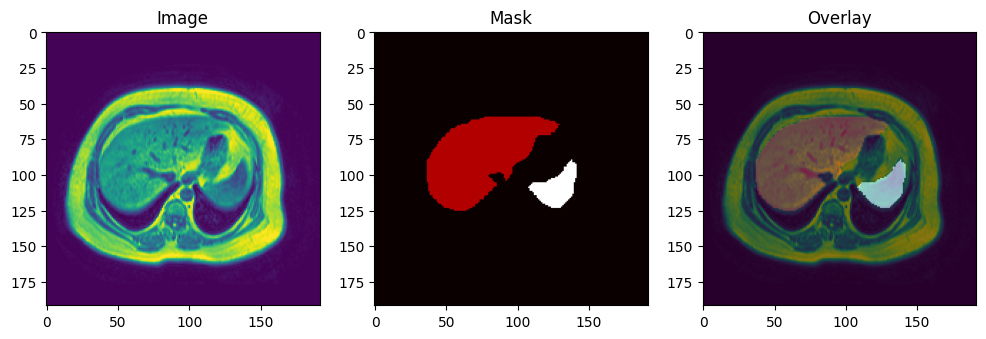

In [23]:
image_viewer(X_train, Y_train, unique_labels)

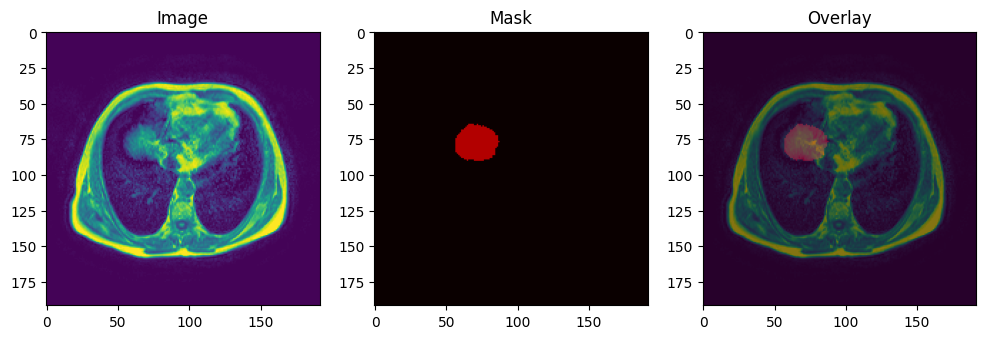

In [24]:
image_viewer(X_validation, Y_validation, unique_labels)

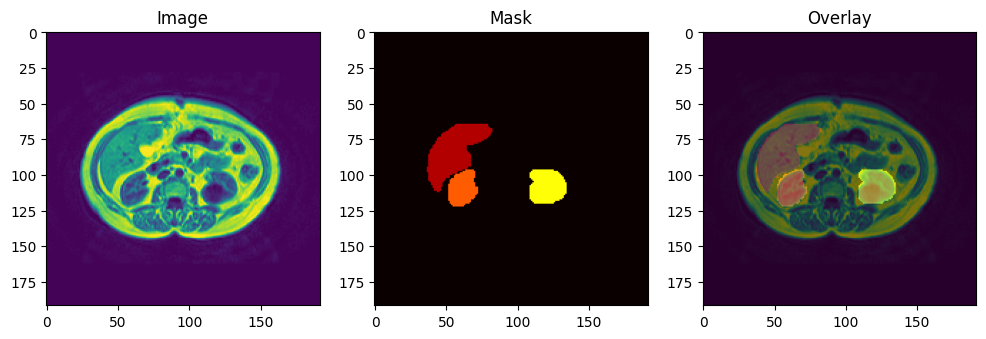

In [25]:
image_viewer(X_test, Y_test, unique_labels)

## NEURAL NETWORK: U-NET

In this section, various U-Net architectures are tested to optimize performance while guarding against overfitting. Architectural parameters such as depth, width, and skip connections are adjusted, and metrics like loss and accuracy are closely monitored. Techniques like dropout and data augmentation are applied as needed to prevent overfitting. The goal is to find an effective U-Net architecture that balances complexity and generalization for segmentation tasks.

In [26]:
# Input shape
input_shape = X_train.shape[1:]

### TRIALS

In [53]:
def unet(pretrained_weights = None,input_size = input_shape, num_classes= NUM_LABELS):
    inputs = tfk.Input(input_size)
    conv1 = tfkl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = tfkl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tfkl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = tfkl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tfkl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = tfkl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tfkl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = tfkl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = tfkl.Dropout(0.5)(conv4)
    pool4 = tfkl.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tfkl.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = tfkl.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = tfkl.Dropout(0.5)(conv5)

    up6 = tfkl.Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(tfkl.UpSampling2D(size=(2, 2))(drop5))
    merge6 = tfkl.concatenate([drop4, up6], axis=3)
    conv6 = tfkl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = tfkl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = tfkl.Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(tfkl.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tfkl.concatenate([conv3, up7], axis=3)
    conv7 = tfkl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = tfkl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = tfkl.Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(tfkl.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tfkl.concatenate([conv2, up8], axis=3)
    conv8 = tfkl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = tfkl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = tfkl.Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(tfkl.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tfkl.concatenate([conv1, up9], axis=3)
    conv9 = tfkl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = tfkl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = tfkl.Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = tfk.Model(inputs=inputs, outputs=conv10)

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

In [28]:
def unet(pretrained_weights = None,input_size = input_shape, num_classes= NUM_LABELS):
    inputs = tfk.Input(input_size)
    conv1 = tfkl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = tfkl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tfkl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = tfkl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tfkl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = tfkl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tfkl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = tfkl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    #drop4 = tfkl.Dropout(0.5)(conv4)
    #pool4 = tfkl.MaxPooling2D(pool_size=(2, 2))(drop4)

    '''
    conv5 = tfkl.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = tfkl.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = tfkl.Dropout(0.5)(conv5)
    '''

    up6 = tfkl.Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(tfkl.UpSampling2D(size=(2, 2))(conv4))
    merge6 = tfkl.concatenate([conv3, up6], axis=3)
    conv6 = tfkl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = tfkl.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = tfkl.Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(tfkl.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tfkl.concatenate([conv2, up7], axis=3)
    conv7 = tfkl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = tfkl.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = tfkl.Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(tfkl.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tfkl.concatenate([conv1, up8], axis=3)
    conv8 = tfkl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = tfkl.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    '''
    up9 = tfkl.Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(tfkl.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tfkl.concatenate([conv1, up9], axis=3)
    conv9 = tfkl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = tfkl.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    '''
    conv10 = tfkl.Conv2D(num_classes, 1, activation='softmax')(conv8)

    model = tfk.Model(inputs=inputs, outputs=conv10)

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

### FINAL MODEL

In [29]:
def unet_version_02(pretrained_weights = None, input_size = input_shape, num_classes= NUM_LABELS):
    # Input layer
    inputs = tfkl.Input(input_size)

    # Encoder (downsampling path)
    def conv_block(x, filters, kernel_size=3, dropout=0.0):
        x = tfkl.Conv2D(filters, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.Conv2D(filters, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(x)
        x = tfkl.BatchNormalization()(x)
        if dropout > 0.0:
            x = tfkl.Dropout(dropout)(x)
        return x
    # Decoder (upsampling path)
    def upconv_block(x, conv_output, filters, kernel_size=3):
        x = tfkl.UpSampling2D(size=(2, 2))(x)
        x = tfkl.Conv2D(filters, 2, activation='relu', padding='same', kernel_initializer='he_normal')(x)
        x = tfkl.concatenate([conv_output, x], axis=3)
        x = conv_block(x, filters, kernel_size)
        return x

    # downsampling
    conv1 = conv_block(inputs, 64)
    pool1 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 512, dropout=0.5)
    pool4 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = conv_block(pool4, 512, dropout=0.5)

    # upsampling
    up6 = upconv_block(conv5, conv4, 512)
    up7 = upconv_block(up6, conv3, 256)
    up8 = upconv_block(up7, conv2, 128)
    up9 = upconv_block(up8, conv1, 64)

    # Output layer
    conv10 = tfkl.Conv2D(num_classes, 1, activation='softmax')(up9)

    # Define the model
    model = tfk.Model(inputs=inputs, outputs=conv10)

    # Load pretrained weights if provided
    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model


In [30]:
model = unet_version_02()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 192, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 192, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 192, 192, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 192, 192, 64)         36928     ['batch_normalization[0][0

## CLASS DEFINITION

### EVALUATION METRICS

Intersection Over Union (IoU) is a number that quantifies the degree of overlap between two boxes. In the case of object detection and segmentation, IoU evaluates the overlap of the Ground Truth and Prediction region. MeanIoU is the average IoU across all classes in a segmentation task
* Reference : https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU

Here's the updated version of the UpdatedMeanIoU class, ensuring that predictions passed to it are class labels rather than probabilities:

In [31]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=None, name="mean_iou", dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

The Dice coefficient, also known as the Sørensen–Dice index, is a statistical measure used to gauge the similarity between two sets. In the context of image segmentation, it is used to compare the pixel-wise agreement between a predicted segmentation map and a ground truth map. It ranges from 0 to 1, where 1 indicates perfect overlap and 0 indicates no overlap.

In [33]:
def dice_coeff(y_true, y_pred, smooth=1):
    y_true_dice = K.flatten(K.one_hot(K.cast(y_true, 'int64'), num_classes=5))
    y_pred_dice = K.flatten(y_pred)

    intersect = K.sum(y_true_dice * y_pred_dice, axis=-1)
    denom = K.sum(y_true_dice * y_true_dice, axis=-1) + K.sum(y_pred_dice * y_pred_dice, axis=-1)


    return K.mean((2. * intersect + smooth) / (denom + smooth))

### LOSS FUNCTIONS

The Dice loss function is commonly used in image segmentation tasks to measure the similarity between predicted and ground truth masks. It's calculated as twice the intersection over the sum of pixels in both masks, subtracted from 1 to form a loss. Minimizing this loss during training encourages the model to produce segmentations that closely match the ground truth. This makes it effective for tasks where precise boundary delineation is important.


*   https://www.tensorflow.org/api_docs/python/tf/keras/losses/Dice



In [35]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

Let's derive a combined loss for image segmentation, incorporating both cross-entropy (CE) loss and Dice loss

In [36]:
def ce_dice_loss(y_true, y_pred, l1=0.2, l2= 0.8):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    loss = l1*cce(y_true, y_pred) + l2*dice_loss(y_true, y_pred)
    return loss

## MODEL TRAINING

These are sets of callbacks and hyperparameters used for training a model

In [37]:
# Hyperparameters
learning_rate = 0.0001
batch_size = 16
epochs = 45

# General callbacks for model training
callabacks = [
    tfk.callbacks.EarlyStopping(patience=10, verbose=1),
    tfk.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1)
]
# Callbacks tailored for Dice coefficient metric
callbacks_per_dice = [
    tfk.callbacks.EarlyStopping(monitor='val_dice_coeff',mode='max',patience=5, verbose=1),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_dice_coeff',mode='max',factor=0.1, patience=3, min_lr=1e-5, verbose=1)
]
# Callbacks tailored for mean Intersection over Union (IoU) metric
callbacks_per_meanIoU = [
    tfk.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience=5, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', mode='max', factor=0.1, patience=3, min_lr=1e-5)
]

In this code snippet, the model is compiled with the following configurations:

* **Optimizer**: AdamW optimizer with a specified learning rate.

* **Loss Function**: Custom loss function ce_dice_loss is used, which likely combines Cross-Entropy and Dice Loss.

* **Metrics**: Several metrics are monitored during training, including accuracy, Dice coefficient, and Mean Intersection over Union (IoU)

In [38]:
model.compile(
    #optimizer=tfk.optimizers.RMSprop(learning_rate),
    loss = ce_dice_loss,
    # Metrics to monitor during training
    metrics = ['Accuracy', dice_coeff, UpdatedMeanIoU(num_classes=NUM_LABELS)],
    #metrics = ['Accuracy']
    #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tfk.optimizers.AdamW(learning_rate),
    #metrics = ["Accuracy", UpdatedMeanIoU(num_classes=NUM_LABELS)]
)

The upcoming block of code will train the model using the training data *X_train* and corresponding labels *Y_train*. The training process will run for 45 *epochs*, with a *batch size* of 16. During training, the model's performance will be monitored using the validation data (*X_validation*, *Y_validation*). Callbacks specifically tailored for *mean Intersection over Union (IoU)* will be utilized to adjust the training based on this metric's performance. The training progress will be displayed with a verbosity level of 2.

In [39]:
history = model.fit(
    x = X_train,
    y = Y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_validation, Y_validation),
    callbacks = callbacks_per_meanIoU,
    verbose = 2
)

Epoch 1/45
180/180 - 177s - loss: 0.4142 - Accuracy: 0.8778 - dice_coeff: 0.7782 - mean_iou: 0.3141 - val_loss: 0.0977 - val_Accuracy: 0.9616 - val_dice_coeff: 0.9506 - val_mean_iou: 0.2842 - lr: 1.0000e-04 - 177s/epoch - 983ms/step
Epoch 2/45
180/180 - 141s - loss: 0.1832 - Accuracy: 0.9834 - dice_coeff: 0.9098 - mean_iou: 0.6778 - val_loss: 0.0285 - val_Accuracy: 0.9891 - val_dice_coeff: 0.9886 - val_mean_iou: 0.7337 - lr: 1.0000e-04 - 141s/epoch - 784ms/step
Epoch 3/45
180/180 - 141s - loss: 0.1061 - Accuracy: 0.9909 - dice_coeff: 0.9539 - mean_iou: 0.7978 - val_loss: 0.0280 - val_Accuracy: 0.9906 - val_dice_coeff: 0.9905 - val_mean_iou: 0.7986 - lr: 1.0000e-04 - 141s/epoch - 781ms/step
Epoch 4/45
180/180 - 137s - loss: 0.0658 - Accuracy: 0.9931 - dice_coeff: 0.9749 - mean_iou: 0.8449 - val_loss: 0.0248 - val_Accuracy: 0.9940 - val_dice_coeff: 0.9928 - val_mean_iou: 0.8506 - lr: 1.0000e-04 - 137s/epoch - 759ms/step
Epoch 5/45
180/180 - 136s - loss: 0.0451 - Accuracy: 0.9941 - dice_c

## LOSS and ACCURACY PLOTS

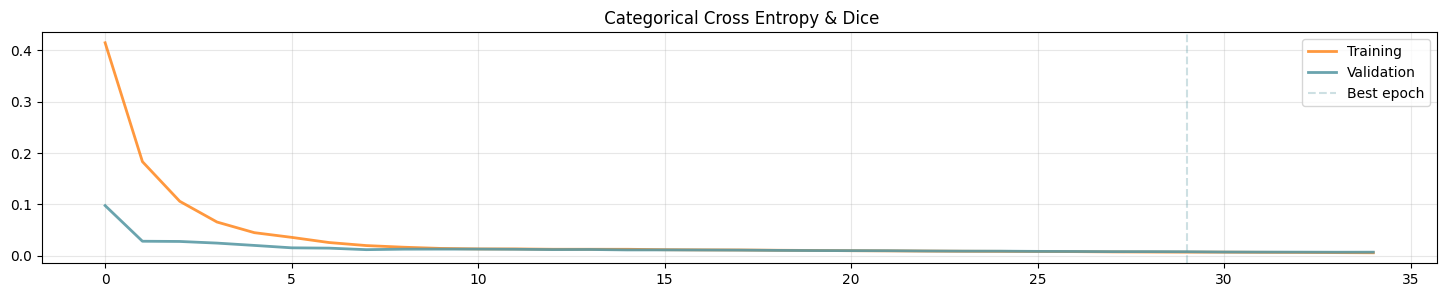

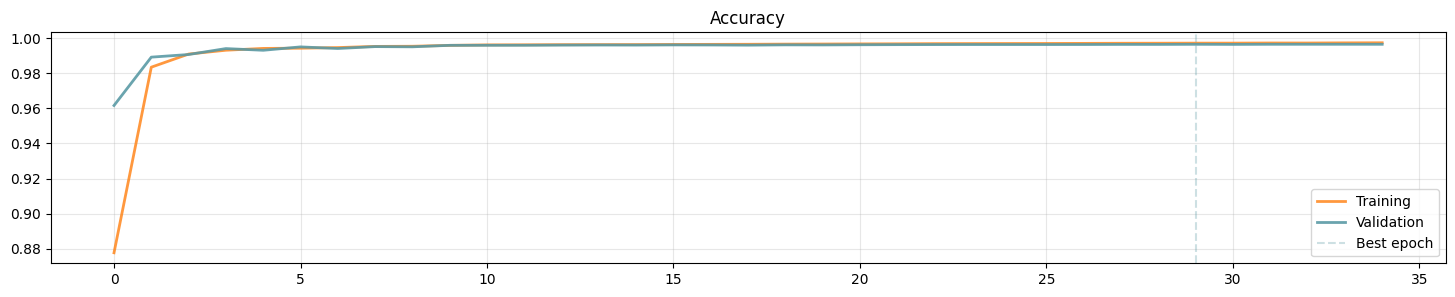

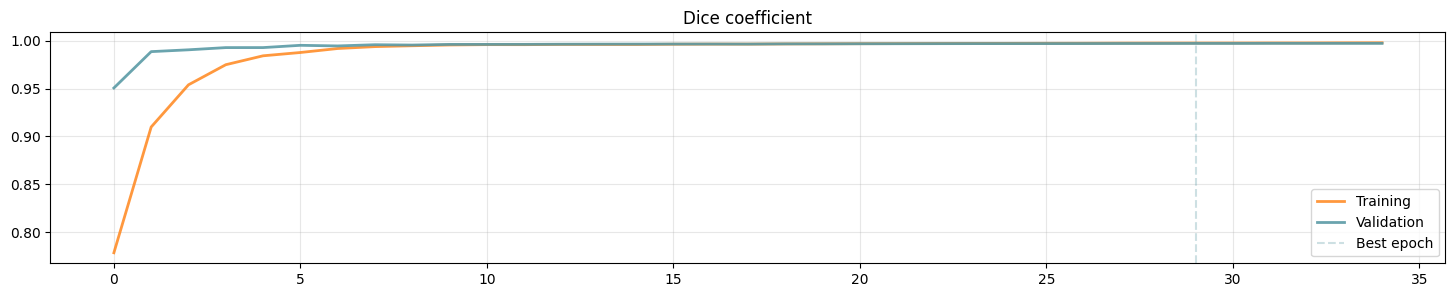

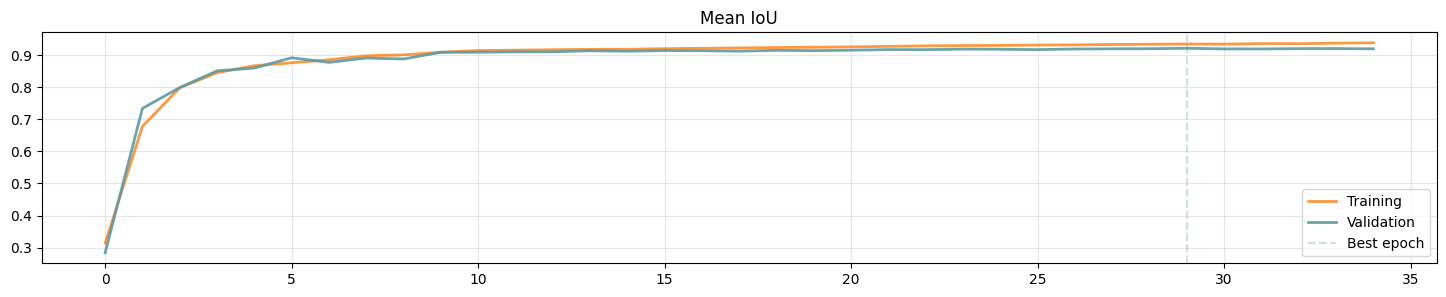

In [40]:
# Find the epoch with the highest validation mean IoU
best_epoch = np.argmax(history.history['val_mean_iou'])

# Plot training and validation loss
plt.figure(figsize=(18,3))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title(' Categorical Cross Entropy & Dice')
plt.legend()
plt.grid(alpha=.3)
# Setting the y-axis range
#plt.ylim(0, 0.5)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(18,3))
plt.plot(history.history['Accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_Accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Plot training and validation Dice coefficient
plt.figure(figsize=(18,3))
plt.plot(history.history['dice_coeff'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_dice_coeff'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Dice coefficient')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Plot training and validation Mean IoU
plt.figure(figsize=(18,3))
plt.plot(history.history['mean_iou'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_mean_iou'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean IoU')
plt.legend()
plt.grid(alpha=.3)
plt.show()

This following code snippet saves the trained model with a unique identifier based on the current date and time

In [41]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_save_path = f"unet_model_{current_time}"
model.save(model_save_path)

## MODEL TESTING

Model testing evaluates how well a trained model performs on unseen data. It assesses the model's generalization ability and identifies potential issues like overfitting. Testing involves evaluating performance metrics on a separate test dataset and guides decisions on model deployment and refinement

In [42]:
# Load model
model = tfk.models.load_model(model_save_path, compile=False)
# Compile model
model.compile(
    #optimizer=tfk.optimizers.RMSprop(learning_rate),
    loss = ce_dice_loss,
    metrics = ['Accuracy', dice_coeff, UpdatedMeanIoU(num_classes=NUM_LABELS)],
    #metrics = ['Accuracy']
    #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tfk.optimizers.AdamW(learning_rate),
    #metrics = ["Accuracy", UpdatedMeanIoU(num_classes=NUM_LABELS)]
)

In [43]:
# Evaluate model on test set
test_loss, test_accuracy, test_dice_coeff, test_mean_iou = model.evaluate(X_test, Y_test, verbose=1, batch_size=10)
print(f"Test Accuracy: {round(test_accuracy, 4)}, Test Dice Coefficient: {round(test_dice_coeff,4)} ,Test Mean Intersection over union: {round(test_mean_iou, 4)}")

39/39 [==============================] - 14s 197ms/step - loss: 0.0410 - Accuracy: 0.9864 - dice_coeff: 0.9886 - mean_iou: 0.7557
Test Accuracy: 0.9864, Test Dice Coefficient: 0.9886 ,Test Mean Intersection over union: 0.7557


## PLOTTING PREDICTIONS

Focus lies on visualizing the model's performance objectively. By juxtaposing predicted outputs with ground truth labels, the aim is to provide an impartial assessment of the model's accuracy.

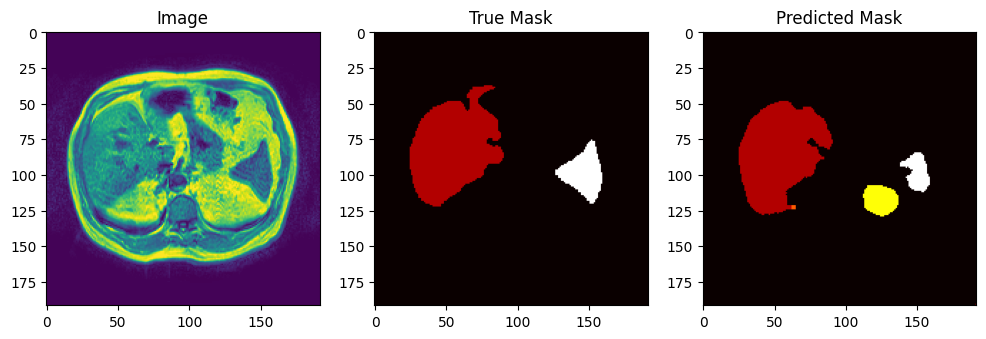

In [50]:
predictions_image_viewer(model, X_test, Y_test, unique_labels)

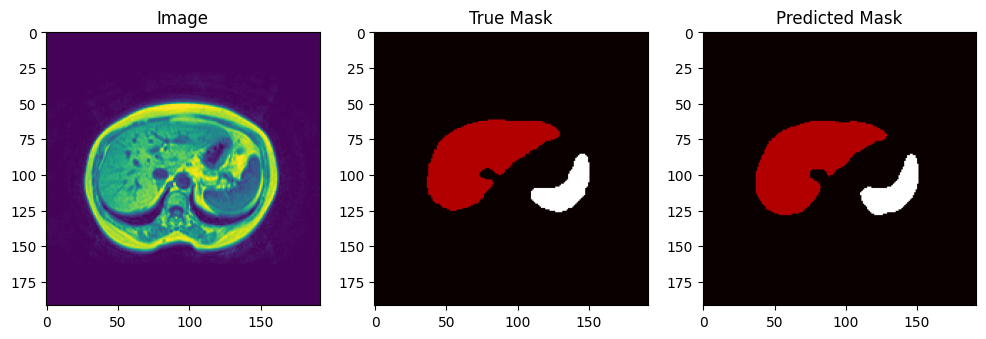

In [51]:
predictions_image_viewer(model, X_test, Y_test, unique_labels)

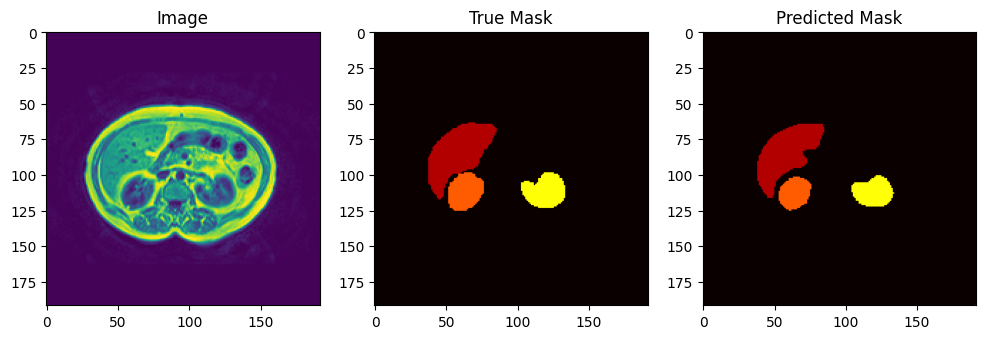

In [52]:
predictions_image_viewer(model, X_test, Y_test, unique_labels)